In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

# 1. Data

이번 실습에서 사용할 데이터는 캘리포니아주의 집 값을 예측하는 데이터 입니다.

1.1 Data Load

데이터는 sklearn.datasets의 fetch_california_housing을 통해 사용할 수 있음

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [3]:
data, target = housing["data"], housing["target"]

In [5]:
# 빠른 실습을 위해서 데이터를 1/10으로 줄임

data.shape

(20640, 8)

In [6]:
data = data[:2000]
target = target[:2000]

1.2 Data EDA

In [7]:
pd.DataFrame(data, columns=housing["feature_names"]).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.885417,31.310500,5.894044,1.151377,1243.354500,2.722148,38.066565,-121.940045
std,1.910350,14.050331,5.124791,1.093032,965.900959,0.757496,0.655932,0.571707
min,0.499900,2.000000,1.714286,0.526316,18.000000,1.280603,36.720000,-124.300000
25%,2.536800,19.000000,4.698539,1.006504,691.000000,2.349835,37.740000,-122.240000
50%,3.508600,32.000000,5.424636,1.051638,1002.500000,2.652805,37.860000,-122.090000
75%,4.924075,43.000000,6.281798,1.104526,1495.000000,2.995032,37.992500,-121.900000
max,15.000100,52.000000,141.909091,34.066667,12203.000000,17.177700,41.950000,-119.770000


In [8]:
pd.Series(target).describe()

count    2000.000000
mean        1.919534
std         0.963947
min         0.225000
25%         1.177750
50%         1.742000
75%         2.409250
max         5.000010
dtype: float64

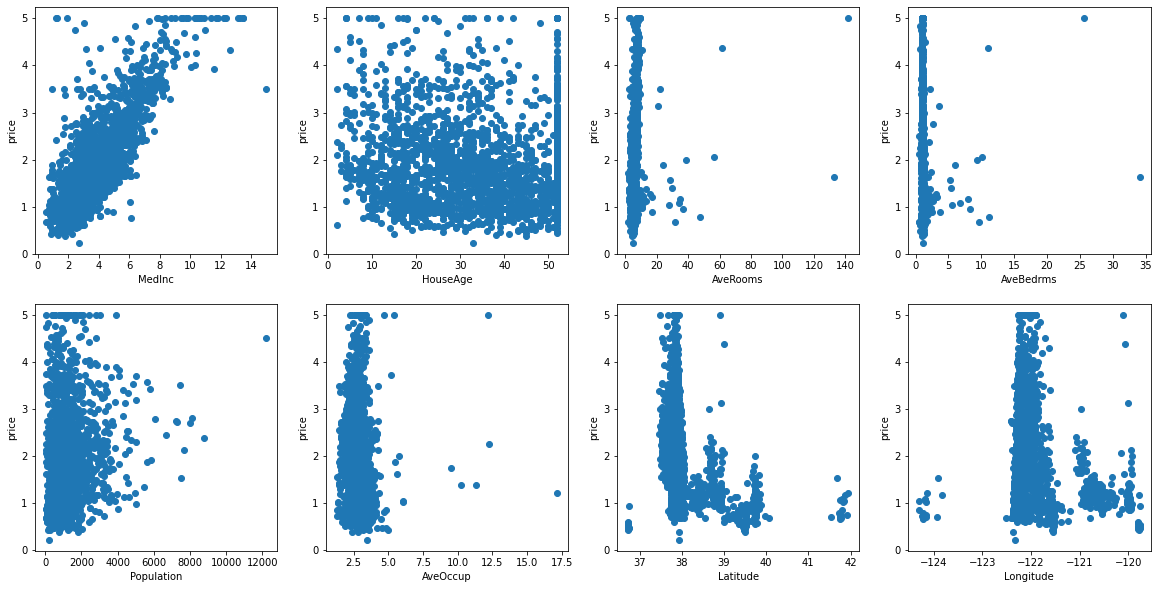

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for i, feature_name in enumerate(housing["feature_names"]):
  ax = axes[i//4, i%4]
  ax.scatter(data[:,i],target)
  ax.set_xlabel(feature_name)
  ax.set_ylabel("price")
  # 아래 그래프들에서 첫번째 그래프 MedInc가 증가했을 때 가격이 증가함

1.3 Data Split

In [10]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(
    data, target, train_size=0.7, random_state=2021
)

# 2.Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor()

2.1 학습

In [12]:
rf_regressor.fit(train_data, train_target)

RandomForestRegressor()

2.2 예측

In [13]:
train_pred = rf_regressor.predict(train_data)
test_pred = rf_regressor.predict(test_data)

Text(0, 0.5, 'real')

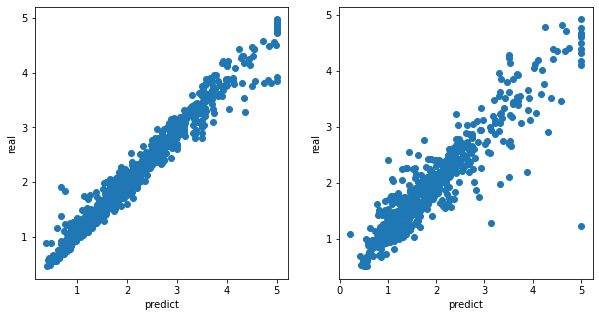

In [14]:
fig, axes = plt.subplots(nrows =1, ncols=2, figsize =(10,5))

axes[0].scatter(train_target, train_pred)
axes[0].set_xlabel("predict")
axes[0].set_ylabel("real")

axes[1].scatter(test_target, test_pred)
axes[1].set_xlabel("predict")
axes[1].set_ylabel("real")

In [16]:
# 가로축 predict, 오른쪽 실제 예측해야되는 값
# 45도로 쭉 있는게 예측 잘한것임
# train은 예측 잘하고, test는 퍼지는 경향이 있음

from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_target, train_pred)
test_mse = mean_squared_error(test_target, test_pred)

In [17]:
print(f"train mean squared error is {train_mse:.4f}")
print(f"test mean squared error is {test_mse:.4f}")

train mean squared error is 0.0274
test mean squared error is 0.1478


2.4 Feature Importance

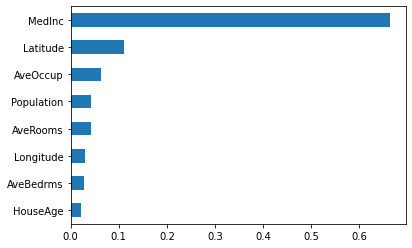

In [18]:
feature_importance = pd.Series(rf_regressor.feature_importances_, index=housing["feature_names"])
feature_importance.sort_values(ascending=True).plot(kind="barh")

# 3. Best Parameter

In [19]:
from sklearn.model_selection import GridSearchCV

Random Forest Regressor에서 설정하는 argument들은 다음과 같음

- n_estimators
 - 몇 개의 의사결정나무를 생성할지 결정함

- criterion
 - 감소 시킬 평가지표를 설정
 - "mae": Mean Absolute Error
 - "mse": Mean Squared Error

- max_depth
 - 의사결정나무가 가질 수 있는 최대 깊이를 결정함

 


3.1 탐색 범위 설정

In [20]:
params = {
    "n_estimators":[100, 200, 500, 1000],
    "criterion":["mae", "mse"],
    "max_depth":[3, 5, 7],
}

In [21]:
params

{'n_estimators': [100, 200, 500, 1000],
 'criterion': ['mae', 'mse'],
 'max_depth': [3, 5, 7]}

In [22]:
cv_rf_regressor = RandomForestRegressor()

3.2 탐색

탐색을 시작합니다.\
cv는 k-fold의 k값 임

In [23]:
grid = GridSearchCV(estimator=cv_rf_regressor, param_grid=params, cv=3, n_jobs=-1) 
# 2*3*4 = 총 24개의 탐색범위 생김. --> cv=3 이여서 총 72개의 모델 생성
# n_jobs = -1 사용할수 있는 job을 사용해서 탐색해라
grid = grid.fit(train_data, train_target)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


In [24]:
print(f"Best score of parameter search is : {grid.best_score_:.4f}")


Best score of parameter search is : 0.7670


In [25]:
grid.best_params_

{'criterion': 'mae', 'max_depth': 7, 'n_estimators': 1000}

In [26]:
print("Best parameter of beset score is")
for key, value in grid.best_params_.items():
  print(f"\t {key}:{value}")

Best parameter of beset score is
	 criterion:mae
	 max_depth:7
	 n_estimators:1000


3.3 평가

In [28]:
best_rf = grid.best_estimator_

In [29]:
cv_train_pred = best_rf.predict(train_data)
cv_test_pred = best_rf.predict(test_data)

Text(0, 0.5, 'real')

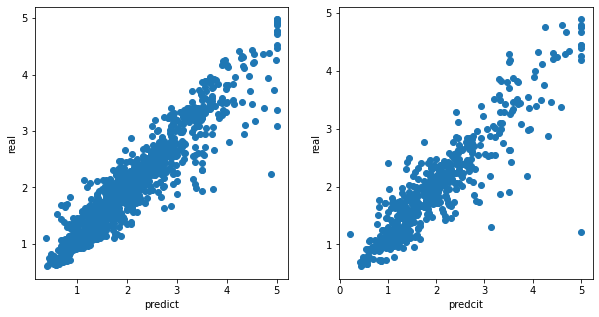

In [30]:
fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(10,5))

axes[0].scatter(train_target, cv_train_pred)
axes[0].set_xlabel("predict")
axes[0].set_ylabel("real")

axes[1].scatter(test_target, cv_test_pred)
axes[1].set_xlabel("predcit")
axes[1].set_ylabel("real")

In [31]:
cv_train_mse = mean_squared_error(train_target, cv_train_pred)
cv_test_mse = mean_squared_error(test_target, cv_test_pred)

In [32]:
print(f"Best model Train mean squared error is {cv_train_mse:.4f}")
print(f"Best model Test mean squared error is {cv_test_mse:.4f}")

Best model Train mean squared error is 0.0974
Best model Test mean squared error is 0.1622


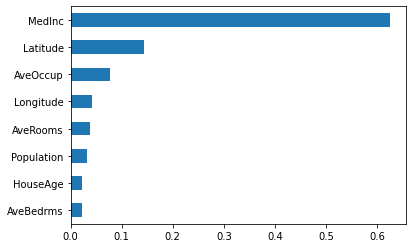

In [34]:
cv_feature_importance = pd.Series(best_rf.feature_importances_, index=housing["feature_names"])
cv_feature_importance.sort_values(ascending=True).plot(kind="barh")

# 4. 마무리

In [35]:
# 튜닝을 하지 않은 모델과, 튜닝한 모델 성능차이 >> 튜닝하지 않는 모델이 정확도가 높음(시간관계상 좁은 범위 탐색하여 튜닝하지 않는 모델 예측값이 더 높음)
print(f"Test mean squared error is {test_mse:.4f}")
print(f"Best model Test man squared error is {cv_test_mse:.4f}")

Test mean squared error is 0.1478
Best model Test man squared error is 0.1622


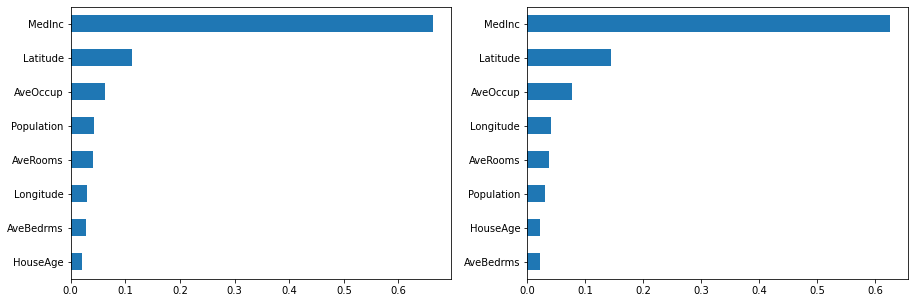

In [36]:
# feature importance 비교
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (15, 5))
feature_importance.sort_values(ascending=True).plot(kind="barh", ax=axes[0])
cv_feature_importance.sort_values(ascending=True).plot(kind="barh", ax=axes[1])